# Deep learning project: Ship recognition in sattelite images
Team members: 
* Csatlós Tamás Péter
* Kalapos András

In this assignment we are going to recognise ships on the surface of the oceans and seas via satelite images. You can find the kaggle challenge here.


In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from imageio import imread
from tqdm import tqdm_notebook
from prettytable import PrettyTable

## Exploring and visualizing the data 

In [25]:
masks_df = pd.read_csv('data/train_ship_segmentations_v2.csv')
print(masks_df.describe())

              ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     99d10330c.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2


In [21]:
masks_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Total number of masks (full dataset size = ships + images without ships):	 231723
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Total number of ships (number of non-empty masks):				 81723

Number of images:								 192556
 ↳Number of images without ships (number of empty masks):			 150000
 ↳Number of images containing a ship:						 42556
   ↳Number of images containing multiple ships:					 15452


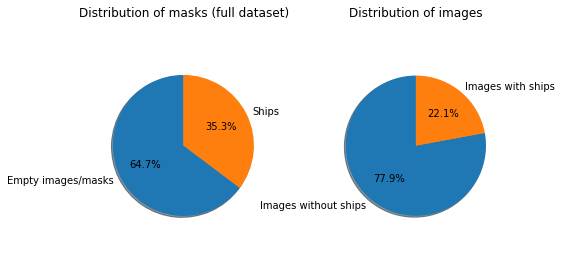

In [24]:
#Note for using  count() and size: size includes NaN values, count does not (https://stackoverflow.com/questions/33346591/what-is-the-difference-between-size-and-count-in-pandas)
#For counting rows of a dataframe we could use len(df.index) or df.shape[0] (the prior should be faster: https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe)

#Important note: if an image contains multiple ships separate masks are defined for each ship

# Number of masks - Size of the total dataset
n_masks = len(masks_df.index)
print("Total number of masks (full dataset size = ships + images without ships):\t", n_masks)

# Number of empty masks - Number of empty images
n_empty_masks = len(masks_df[masks_df['EncodedPixels'].isnull()].index)
print(" ↳Number of images without ships (number of empty masks):\t\t\t", n_empty_masks)

# Number of not empty masks - Number of ships
n_ships = masks_df.count()['EncodedPixels']
print(" ↳Total number of ships (number of non-empty masks):\t\t\t\t", n_ships)

# Number of images
n_images = masks_df.nunique()['ImageId']
print("\nNumber of images:\t\t\t\t\t\t\t\t", n_images)

# Number of images without ships (number of empty masks)
n_im_wo_ship = masks_df[masks_df['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images without ships (number of empty masks):\t\t\t",n_im_wo_ship)

# Number of images containing a ship
n_im_with_ship = masks_df[~masks_df['EncodedPixels'].isnull()].nunique()['ImageId']
print(" ↳Number of images containing a ship:\t\t\t\t\t\t", n_im_with_ship)

#Number of images containing multiple ships
n_im_multi_ship = masks_df[masks_df['ImageId'].duplicated()].nunique()['ImageId']
print("   ↳Number of images containing multiple ships:\t\t\t\t\t", n_im_multi_ship)

# Pie chart
#https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
labels = ['Empty images/masks', 'Ships']
sizes = [n_empty_masks, n_ships]
plt.subplot(1,2,1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of masks (full dataset)')
plt.tight_layout()

#Distribution of images
labels = ['Images without ships', 'Images with ships']
sizes = [n_im_wo_ship, n_im_with_ship]
plt.subplot(1,2,2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of images')
plt.tight_layout()

plt.subplots_adjust( wspace=0.5)

Number of ships per image:
count    192556.000000
mean          0.424412
std           1.199094
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: EncodedPixels, dtype: float64

Histogram of number of ships per image
+---------------------------+--------+
| Number of ships per image | Count  |
+---------------------------+--------+
|            0.0            | 150000 |
|            1.0            | 27104  |
|            2.0            |  7674  |
|            3.0            |  2954  |
|            4.0            |  1622  |
|            5.0            |  925   |
|            6.0            |  657   |
|            7.0            |  406   |
|            8.0            |  318   |
|            9.0            |  243   |
|            10.0           |  168   |
|            11.0           |  144   |
|            12.0           |  124   |
|            13.0           |   75   |
|            14.0           |   76   |
|          

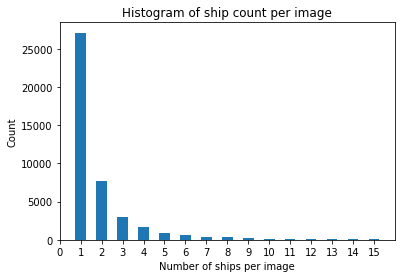

In [29]:
ship_per_img = masks_df.groupby('ImageId').count().iloc[:,0]
print("Number of ships per image:")
print(ship_per_img.describe())

print("\nHistogram of number of ships per image")
[count, bins] = np.histogram(ship_per_img,bins=ship_per_img.max()+1,range=(0,ship_per_img.max()+1))
x = PrettyTable()
x.add_column("Number of ships per image",bins[:-1])
x.add_column("Count", count)
print(x)

plt.hist(ship_per_img,bins=ship_per_img.max(),range=(1,ship_per_img.max()+1),rwidth=0.5, align='left');
plt.xticks(np.arange(ship_per_img.min(), ship_per_img.max()+1, step=1));
plt.xlabel("Number of ships per image");
plt.ylabel("Count");
plt.title("Histogram of ship count per image");

Note: for better visiblity we removed the count of images whithout a ship from the histogram.

Conclusion: most of the images with ships contain only a few ships

In [7]:
# Reference: https://www.kaggle.com/inversion/run-length-decoding-quick-start
# mask_rle: run-length as string formated (start length)
# shape: (height,width) of array to return 
# Returns numpy array, 1 - ship 0 - background
# If mask_rle mask is nan, the returned numpy array only contains zeros
def rle_decode(mask_rle, shape=(768, 768)):
    # Create the all zero mask
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    if mask_rle == mask_rle: # if mask_rle is nan that this equality check returns false
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        
    return img.reshape(shape).T  # Needed to align to RLE direction

In [8]:
# calculate ship-noship ratio for each mask and sum for each mask
ShipSize = np.zeros(len(masks_df.index))
pbar = tqdm_notebook(total=len(masks_df.index))
for index, row in masks_df.iterrows():
    mask = row['EncodedPixels']
    if mask == mask: #If mask is nan, mask == mask is returns false
        ShipSize[index] = np.sum(rle_decode(mask))/(768*768)
    pbar.update(1)
pbar.close()

pd.Series(ShipSize*100).describe()

count    231723.000000
mean          0.093720
std           0.313059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.022464
max           4.391819
dtype: float64

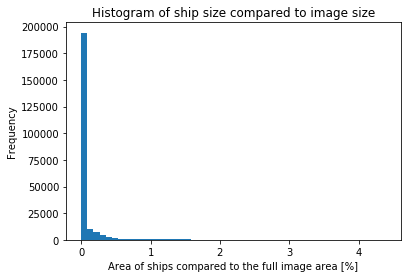

In [9]:
plt.hist(ShipSize*100,bins=50);
plt.xlabel("Area of ships compared to the full image area [%]");
plt.ylabel("Frequency");
plt.title("Histogram of ship size compared to image size");

Conclusion: Most of the ships are very small, smaller that 0.1% of an image.

In [10]:
## This cell is only necessary if not all the training image files are present in the images folder
import os

# This method takes ages
# for idx, img_file in tqdm_notebook(masks.iterrows()):
#     ImageId = img_file["ImageId"]
#     if ~os.path.isfile('data/images'+ImageId): 
#         masksdf=masksdf[masksdf.ImageId!=ImageId]

img_files = os.listdir('data/images')

masks_df['img_found'] = False
for img_file in img_files:
    masks_df['img_found'] = (masks_df['img_found']) | (masks_df['ImageId']==img_file)
masks_df = masks_df[masks_df['img_found']]
masks_df = masks_df.drop('img_found',axis = 1)

masks_df = masks_df.reset_index(drop=True)

Examples for
 Thightly packed, merged ships
 Sationary and moving ships
 Non-ship objelcts 
 Very small ships
 Inland images


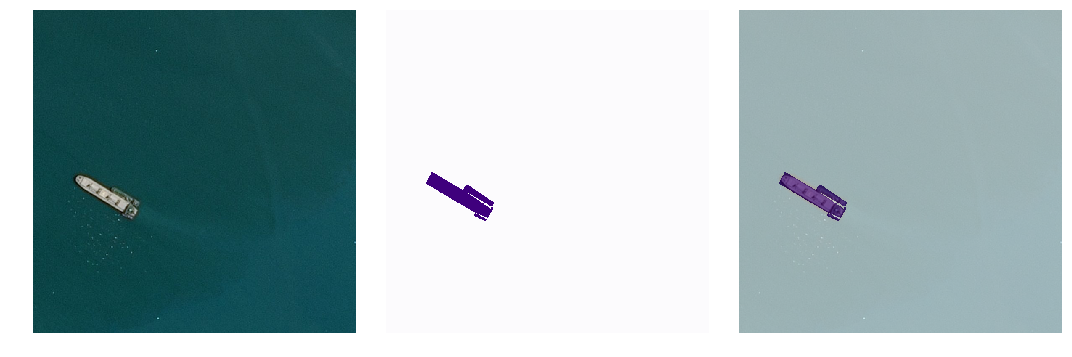

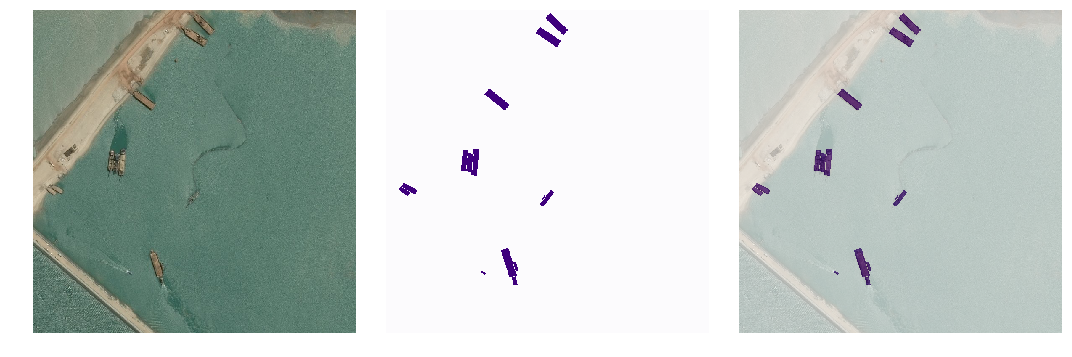

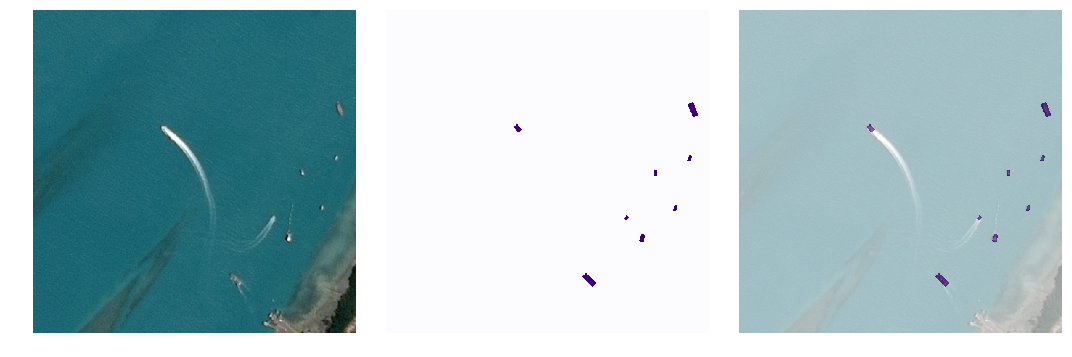

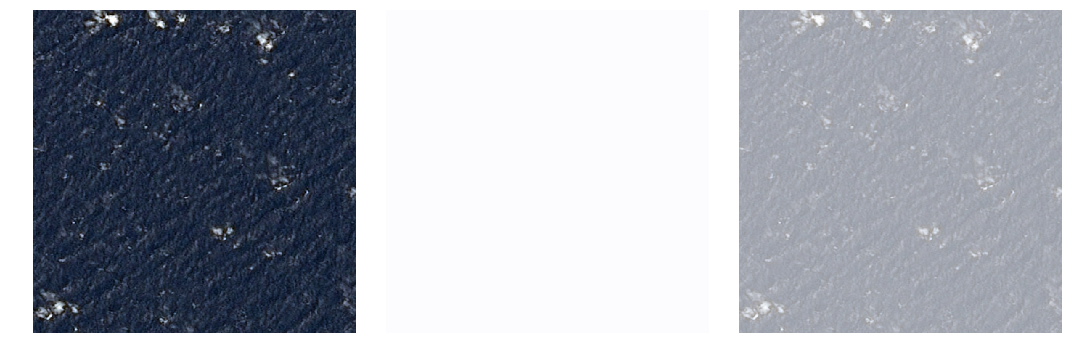

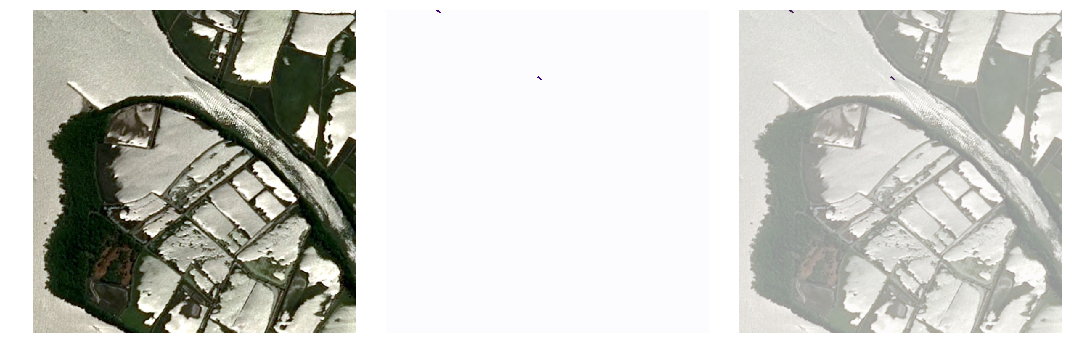

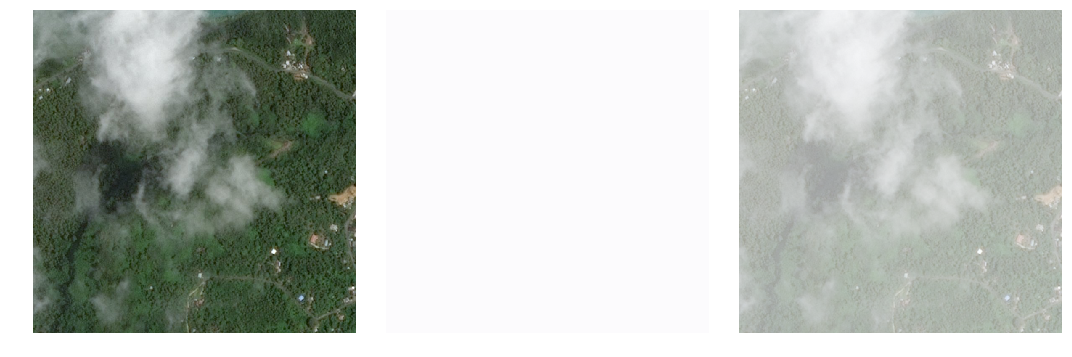

In [33]:
def DispImageWithMap(ImageId):
    img = imread('data/images/' + ImageId)
    img_masks = masks_df.loc[masks_df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += rle_decode(mask)

    fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].imshow(img)
    axarr[1].imshow(all_masks,cmap='Purples')
    axarr[2].imshow(img)
    axarr[2].imshow(all_masks, alpha=0.6,cmap='Purples')
    plt.tight_layout(h_pad=0.1, w_pad=0.1)
    plt.show()

print("Examples for")
print(" Thightly packed, merged ships")
print(" Sationary and moving ships")
print(" Non-ship objelcts \n Very small ships")
print(" Inland images")
DispImageWithMap('0a0df8299.jpg')
DispImageWithMap('0a1a7f395.jpg')
DispImageWithMap('0a2e15e29.jpg')
DispImageWithMap('0a2f58d54.jpg')
DispImageWithMap('0a4ad0982.jpg')
DispImageWithMap('0a3ab4644.jpg')


## Preparing the data for learning 